In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Training GCN model for normal data...
Epoch 0/10, Loss: 1.1251654624938965
Training GCN model for carriage damage data...
Epoch 0/10, Loss: 1.5382806062698364
Training GCN model for high-speed damage data...
Epoch 0/10, Loss: 1.2389934062957764
Training GCN model for lack of lubrication data...
Epoch 0/10, Loss: 1.9425896406173706
Training GCN model for corrosion data...
Epoch 0/10, Loss: 1.5563358068466187
Computing STFT...
Train data shape: (18744, 128, 3, 3)
Test data shape: (4686, 128, 3, 3)
Train data shape after reshape: (18744, 128, 9)
Test data shape after reshape: (4686, 128, 9)
Training LSTM Autoencoder model with Attention...
Epoch 1/5
147/147 [==============================] - 12s 39ms/step - loss: 0.0303 - val_loss: 0.0277
Epoch 2/5
147/147 [==============================] - 4s 26ms/step - loss: 0.0276 - val_loss: 0.0274
Epoch 3/5
147/147 [==============================] - 4s 27ms/step - loss: 0.0275 - val_loss: 0.0272
Epoch 4/5
147/147 [==============================] - 3

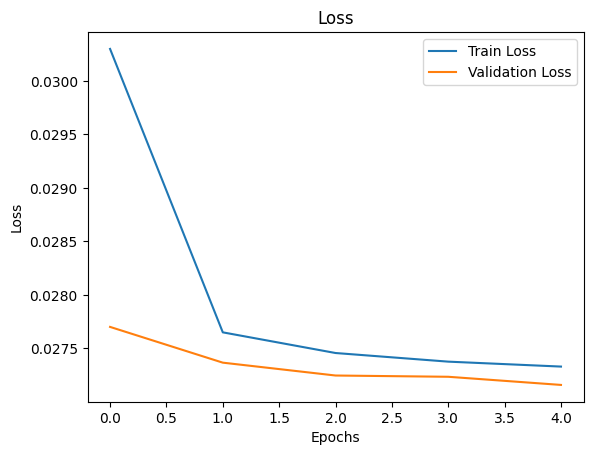

147/147 [==============================] - 1s 5ms/step


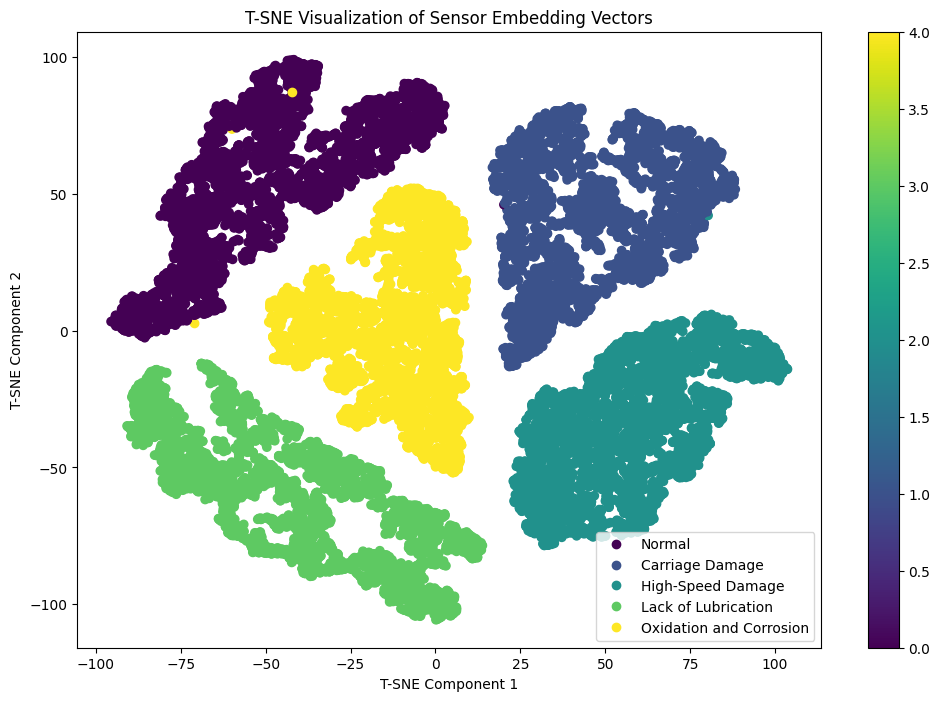

Training classifier model...
Epoch 1/1000
586/586 [==============================] - 4s 6ms/step - loss: 0.6357 - accuracy: 0.7724 - val_loss: 0.0968 - val_accuracy: 0.9876
Epoch 2/1000
586/586 [==============================] - 3s 4ms/step - loss: 0.1409 - accuracy: 0.9604 - val_loss: 0.0198 - val_accuracy: 0.9972
Epoch 3/1000
586/586 [==============================] - 2s 4ms/step - loss: 0.0717 - accuracy: 0.9803 - val_loss: 0.0068 - val_accuracy: 0.9991
Epoch 4/1000
586/586 [==============================] - 2s 4ms/step - loss: 0.0449 - accuracy: 0.9868 - val_loss: 0.0047 - val_accuracy: 0.9998
Epoch 5/1000
586/586 [==============================] - 2s 4ms/step - loss: 0.0326 - accuracy: 0.9909 - val_loss: 0.0041 - val_accuracy: 0.9985
Epoch 6/1000
586/586 [==============================] - 3s 5ms/step - loss: 0.0242 - accuracy: 0.9926 - val_loss: 0.0022 - val_accuracy: 0.9998
Epoch 7/1000
586/586 [==============================] - 3s 5ms/step - loss: 0.0213 - accuracy: 0.9937 - val

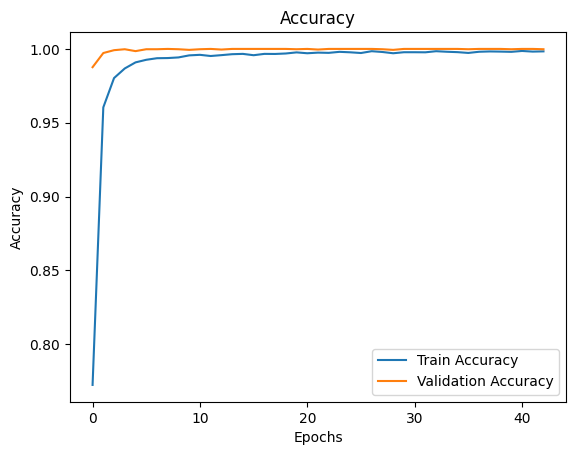

147/147 [==============================] - 0s 2ms/step


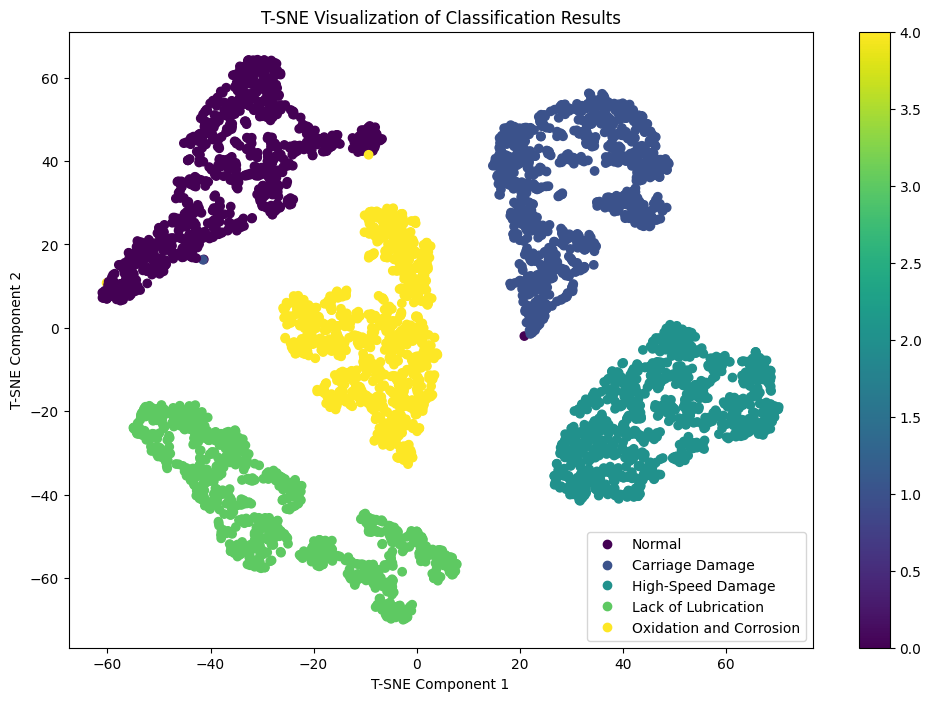

Accuracy on test set: 0.9997865983781477
                         precision    recall  f1-score   support

                 Normal       1.00      1.00      1.00       937
        Carriage Damage       1.00      1.00      1.00       938
      High-Speed Damage       1.00      1.00      1.00       937
    Lack of Lubrication       1.00      1.00      1.00       937
Oxidation and Corrosion       1.00      1.00      1.00       937

               accuracy                           1.00      4686
              macro avg       1.00      1.00      1.00      4686
           weighted avg       1.00      1.00      1.00      4686



In [6]:
################################ LSTM Autoencoder Attention #############################################
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import scipy.signal
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE
from keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# 데이터 파일 로드 및 정규화
def normalize_data(df, features):
    scaler = StandardScaler()
    return scaler.fit_transform(df[features])

# 데이터 파일 로드
normal_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm normal data/stream2024_4_22_23_22.csv")
carriage_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm carriage damage/stream2024_4_23_2_56.csv")
highspeed_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm high-speed damage/stream2024_4_23_0_20.csv")
lack_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm lack of lubrication/stream2024_4_23_2_6.csv")
corrosion_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm oxidation and corrosion/stream2024_4_23_1_15.csv")

features = ['motor1_x', 'motor1_y', 'motor1_z', 'sound']
normal_data_scaled = normalize_data(normal_data, features)
carriage_data_scaled = normalize_data(carriage_data, features)
highspeed_data_scaled = normalize_data(highspeed_data, features)
lack_data_scaled = normalize_data(lack_data, features)
corrosion_data_scaled = normalize_data(corrosion_data, features)

def create_graph_data(data, k_neighbors=2):
    knn_graph = kneighbors_graph(data, k_neighbors, mode='connectivity', include_self=True)
    edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)
    x = torch.tensor(data, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

normal_graph = create_graph_data(normal_data_scaled)
carriage_graph = create_graph_data(carriage_data_scaled)
highspeed_graph = create_graph_data(highspeed_data_scaled)
lack_graph = create_graph_data(lack_data_scaled)
corrosion_graph = create_graph_data(corrosion_data_scaled)

# GCN 모델 정의
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# GCN 모델 학습 및 특징 추출
def train_gcn(graph_data, epochs=10):
    model = GCN(in_channels=graph_data.x.shape[1], hidden_channels=16, out_channels=graph_data.x.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph_data)
        loss = F.mse_loss(out, graph_data.x)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
    return model, out.detach().numpy()

print("Training GCN model for normal data...")
normal_model, normal_gcn_features = train_gcn(normal_graph)
print("Training GCN model for carriage damage data...")
carriage_model, carriage_gcn_features = train_gcn(carriage_graph)
print("Training GCN model for high-speed damage data...")
highspeed_model, highspeed_gcn_features = train_gcn(highspeed_graph)
print("Training GCN model for lack of lubrication data...")
lack_model, lack_gcn_features = train_gcn(lack_graph)
print("Training GCN model for corrosion data...")
corrosion_model, corrosion_gcn_features = train_gcn(corrosion_graph)

# 슬라이딩 윈도우 함수 정의
def sliding_window(data, window_size, step_size):
    n_samples = data.shape[0]
    windows = []
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return np.array(windows)

window_size = 128
step_size = 64

# 슬라이딩 윈도우 적용
normal_windows = sliding_window(normal_gcn_features, window_size, step_size)
carriage_windows = sliding_window(carriage_gcn_features, window_size, step_size)
highspeed_windows = sliding_window(highspeed_gcn_features, window_size, step_size)
lack_windows = sliding_window(lack_gcn_features, window_size, step_size)
corrosion_windows = sliding_window(corrosion_gcn_features, window_size, step_size)

# STFT 수행
fs = 5000
def compute_stft(data):
    return np.array([np.abs(scipy.signal.stft(d, fs=fs, nperseg=min(d.shape[-1], 256))[2]) for d in data])  # 절대값을 사용하여 실수 데이터로 변환

print("Computing STFT...")
normal_stft = compute_stft(normal_windows)
carriage_stft = compute_stft(carriage_windows)
highspeed_stft = compute_stft(highspeed_windows)
lack_stft = compute_stft(lack_windows)
corrosion_stft = compute_stft(corrosion_windows)

# 데이터 합치기
def concatenate_data(*stft_data):
    min_time_steps = min(stft.shape[2] for stft in stft_data)
    return np.concatenate([stft[:, :, :min_time_steps] for stft in stft_data], axis=0)

X_normal = concatenate_data(normal_stft)
X_carriage = concatenate_data(carriage_stft)
X_highspeed = concatenate_data(highspeed_stft)
X_lack = concatenate_data(lack_stft)
X_corrosion = concatenate_data(corrosion_stft)

# 레이블 생성
y_normal = np.zeros(X_normal.shape[0])
y_carriage = np.ones(X_carriage.shape[0])
y_highspeed = np.full((X_highspeed.shape[0],), 2)
y_lack = np.full((X_lack.shape[0],), 3)
y_corrosion = np.full((X_corrosion.shape[0],), 4)

# 데이터셋 합치기
X = np.concatenate((X_normal, X_carriage, X_highspeed, X_lack, X_corrosion), axis=0)
y = np.concatenate((y_normal, y_carriage, y_highspeed, y_lack, y_corrosion), axis=0)

# 레이블을 원-핫 인코딩으로 변환
y = to_categorical(y)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 형태 확인
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# 데이터 형태 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)  # (샘플 수, 시간, 특징 수)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
print("Train data shape after reshape:", X_train.shape)
print("Test data shape after reshape:", X_test.shape)

# LSTM Autoencoder 모델 정의 (Attention 추가)
def create_lstm_ae_with_attention(input_shape):
    inputs = Input(shape=input_shape)
    encoded = LSTM(64, return_sequences=True)(inputs)
    encoded = LSTM(32, return_sequences=True)(encoded)
    attention = Attention()(encoded)
    repeated = RepeatVector(input_shape[0])(attention)
    decoded = LSTM(32, return_sequences=True)(repeated)
    decoded = LSTM(64, return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(input_shape[1]))(decoded)
    model = Model(inputs, outputs)
    return model

input_shape = (X_train.shape[1], X_train.shape[2])  # (시간, 특징 수)
model = create_lstm_ae_with_attention(input_shape)

model.compile(optimizer='adam', loss='mse')

# 얼리스탑 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# 모델 훈련
print("Training LSTM Autoencoder model with Attention...")
history = model.fit(X_train, X_train, epochs=5, batch_size=128, validation_data=(X_test, X_test), callbacks=[early_stopping])

# 모델 서머리
model.summary()

# 훈련 및 검증 데이터에 대한 손실 확인
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 훈련 및 검증 데이터에 대한 손실 그래프
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# LSTM Autoencoder에서 인코딩된 특징 추출
encoder = Model(inputs=model.input, outputs=model.layers[3].output)

X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# T-SNE를 사용한 시각화
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(np.concatenate((X_train_encoded, X_test_encoded)))

# 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.argmax(np.concatenate((y_train, y_test)), axis=1), cmap='viridis')
plt.colorbar()
plt.title("T-SNE Visualization of Sensor Embedding Vectors")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion'])
plt.show()

# 다중 클래스 분류 모델 정의
classifier = Sequential()
classifier.add(Dense(64, input_shape=(X_train_encoded.shape[1],)))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.5))
classifier.add(Dense(32))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.2))
classifier.add(Dense(y_train.shape[1], activation='softmax'))

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 다중 클래스 분류 모델 훈련
print("Training classifier model...")
history = classifier.fit(X_train_encoded, y_train, epochs=1000, batch_size=32, validation_data=(X_test_encoded, y_test), callbacks=[early_stopping])

# 분류 모델 서머리
classifier.summary()

# 훈련 및 검증 데이터에 대한 손실 및 정확도 확인
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 훈련 및 검증 데이터에 대한 손실 및 정확도 그래프
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 테스트 데이터에 대한 예측 및 평가
y_test_pred = classifier.predict(X_test_encoded)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# 분류 결과의 T-SNE 시각화
X_test_tsne = tsne.fit_transform(X_test_encoded)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test_pred_classes, cmap='viridis')
plt.colorbar()
plt.title("T-SNE Visualization of Classification Results")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion'])
plt.show()

print("Accuracy on test set:", accuracy_score(y_test_true_classes, y_test_pred_classes))
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion']))

Training GCN model for normal data...
Epoch 0/10, Loss: 1.3539828062057495
Training GCN model for carriage damage data...
Epoch 0/10, Loss: 1.2032638788223267
Training GCN model for high-speed damage data...
Epoch 0/10, Loss: 1.3551262617111206
Training GCN model for lack of lubrication data...
Epoch 0/10, Loss: 1.2637640237808228
Training GCN model for corrosion data...
Epoch 0/10, Loss: 1.2268024682998657
Computing STFT...
Train data shape: (18744, 128, 3, 3)
Test data shape: (4686, 128, 3, 3)
Train data shape after reshape: (18744, 128, 9)
Test data shape after reshape: (4686, 128, 9)
Training LSTM Autoencoder model...
Epoch 1/5
147/147 [==============================] - 12s 32ms/step - loss: 0.0408 - val_loss: 0.0384
Epoch 2/5
147/147 [==============================] - 3s 22ms/step - loss: 0.0374 - val_loss: 0.0378
Epoch 3/5
147/147 [==============================] - 5s 31ms/step - loss: 0.0372 - val_loss: 0.0377
Epoch 4/5
147/147 [==============================] - 3s 23ms/step - l

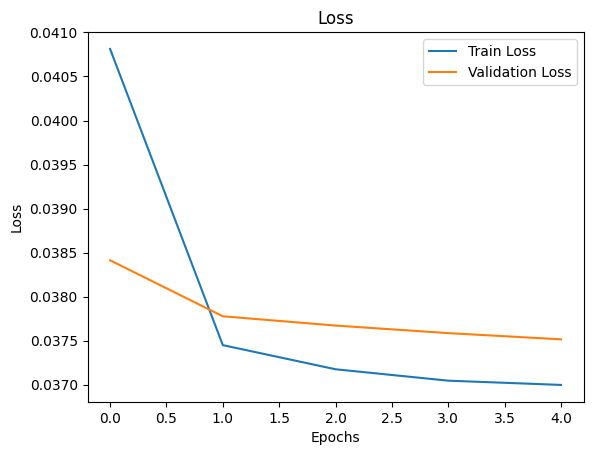

147/147 [==============================] - 1s 5ms/step


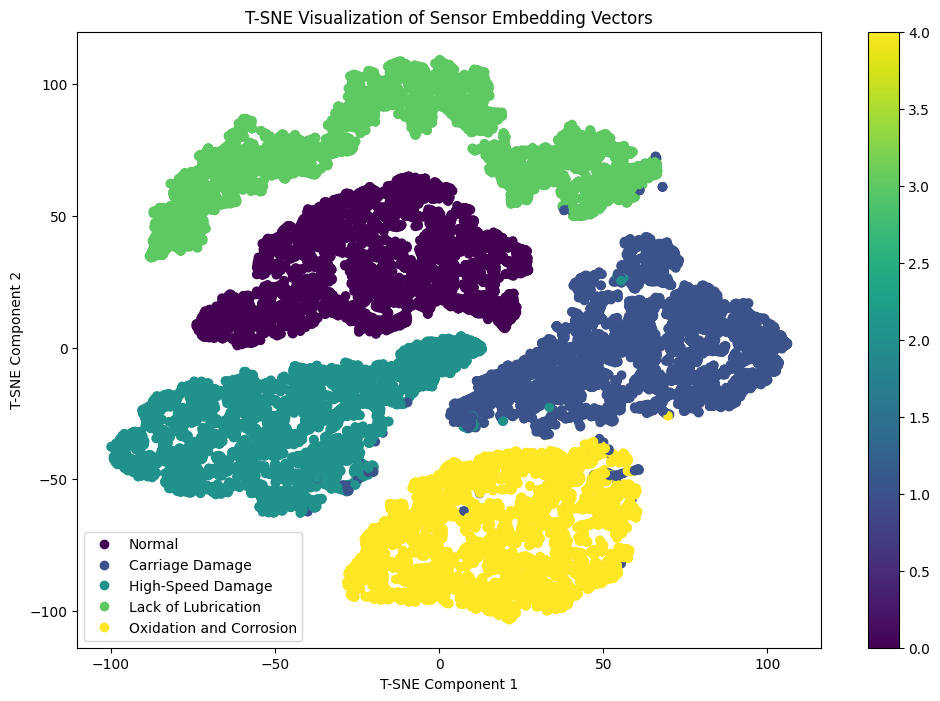

Training classifier model...
Epoch 1/1000
586/586 [==============================] - 3s 4ms/step - loss: 0.5524 - accuracy: 0.8235 - val_loss: 0.0392 - val_accuracy: 0.9951
Epoch 2/1000
586/586 [==============================] - 2s 4ms/step - loss: 0.1159 - accuracy: 0.9689 - val_loss: 0.0206 - val_accuracy: 0.9947
Epoch 3/1000
586/586 [==============================] - 2s 4ms/step - loss: 0.0705 - accuracy: 0.9788 - val_loss: 0.0141 - val_accuracy: 0.9957
Epoch 4/1000
586/586 [==============================] - 3s 5ms/step - loss: 0.0565 - accuracy: 0.9831 - val_loss: 0.0129 - val_accuracy: 0.9966
Epoch 5/1000
586/586 [==============================] - 3s 5ms/step - loss: 0.0481 - accuracy: 0.9852 - val_loss: 0.0123 - val_accuracy: 0.9970
Epoch 6/1000
586/586 [==============================] - 2s 4ms/step - loss: 0.0449 - accuracy: 0.9849 - val_loss: 0.0126 - val_accuracy: 0.9962
Epoch 7/1000
586/586 [==============================] - 2s 4ms/step - loss: 0.0400 - accuracy: 0.9876 - val

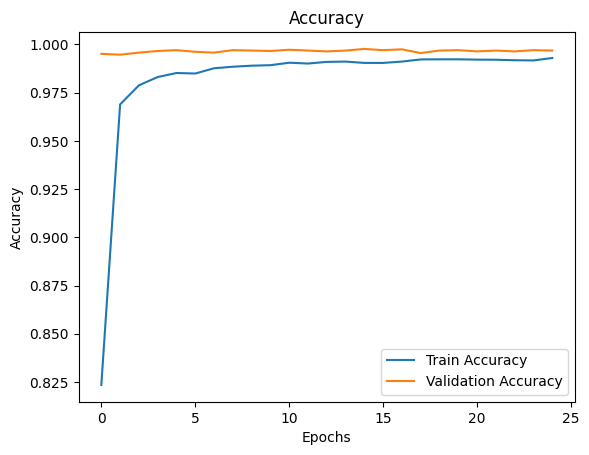

147/147 [==============================] - 0s 2ms/step


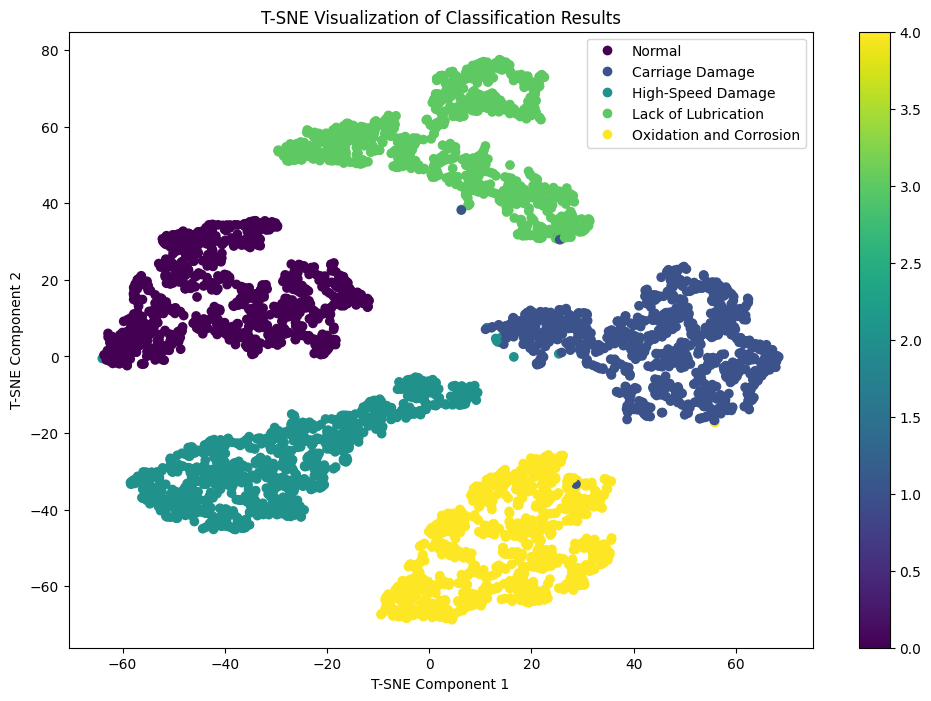

Accuracy on test set: 0.9967989756722151
                         precision    recall  f1-score   support

                 Normal       1.00      1.00      1.00       937
        Carriage Damage       0.99      0.99      0.99       938
      High-Speed Damage       0.99      1.00      0.99       937
    Lack of Lubrication       1.00      1.00      1.00       937
Oxidation and Corrosion       1.00      1.00      1.00       937

               accuracy                           1.00      4686
              macro avg       1.00      1.00      1.00      4686
           weighted avg       1.00      1.00      1.00      4686



In [7]:
####################################### LSTM Autoencoder  #############################################
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import scipy.signal
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE
from keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# 데이터 파일 로드 및 정규화
def normalize_data(df, features):
    scaler = StandardScaler()
    return scaler.fit_transform(df[features])

# 데이터 파일 로드
normal_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm normal data/stream2024_4_22_23_22.csv")
carriage_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm carriage damage/stream2024_4_23_2_56.csv")
highspeed_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm high-speed damage/stream2024_4_23_0_20.csv")
lack_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm lack of lubrication/stream2024_4_23_2_6.csv")
corrosion_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm oxidation and corrosion/stream2024_4_23_1_15.csv")

features = ['motor1_x', 'motor1_y', 'motor1_z', 'sound']
normal_data_scaled = normalize_data(normal_data, features)
carriage_data_scaled = normalize_data(carriage_data, features)
highspeed_data_scaled = normalize_data(highspeed_data, features)
lack_data_scaled = normalize_data(lack_data, features)
corrosion_data_scaled = normalize_data(corrosion_data, features)

def create_graph_data(data, k_neighbors=2):
    knn_graph = kneighbors_graph(data, k_neighbors, mode='connectivity', include_self=True)
    edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)
    x = torch.tensor(data, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

normal_graph = create_graph_data(normal_data_scaled)
carriage_graph = create_graph_data(carriage_data_scaled)
highspeed_graph = create_graph_data(highspeed_data_scaled)
lack_graph = create_graph_data(lack_data_scaled)
corrosion_graph = create_graph_data(corrosion_data_scaled)

# GCN 모델 정의
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# GCN 모델 학습 및 특징 추출
def train_gcn(graph_data, epochs=10):
    model = GCN(in_channels=graph_data.x.shape[1], hidden_channels=16, out_channels=graph_data.x.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph_data)
        loss = F.mse_loss(out, graph_data.x)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
    return model, out.detach().numpy()

print("Training GCN model for normal data...")
normal_model, normal_gcn_features = train_gcn(normal_graph)
print("Training GCN model for carriage damage data...")
carriage_model, carriage_gcn_features = train_gcn(carriage_graph)
print("Training GCN model for high-speed damage data...")
highspeed_model, highspeed_gcn_features = train_gcn(highspeed_graph)
print("Training GCN model for lack of lubrication data...")
lack_model, lack_gcn_features = train_gcn(lack_graph)
print("Training GCN model for corrosion data...")
corrosion_model, corrosion_gcn_features = train_gcn(corrosion_graph)

# 슬라이딩 윈도우 함수 정의
def sliding_window(data, window_size, step_size):
    n_samples = data.shape[0]
    windows = []
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return np.array(windows)

window_size = 128
step_size = 64

# 슬라이딩 윈도우 적용
normal_windows = sliding_window(normal_gcn_features, window_size, step_size)
carriage_windows = sliding_window(carriage_gcn_features, window_size, step_size)
highspeed_windows = sliding_window(highspeed_gcn_features, window_size, step_size)
lack_windows = sliding_window(lack_gcn_features, window_size, step_size)
corrosion_windows = sliding_window(corrosion_gcn_features, window_size, step_size)

# STFT 수행
fs = 5000
def compute_stft(data):
    return np.array([np.abs(scipy.signal.stft(d, fs=fs, nperseg=min(d.shape[-1], 256))[2]) for d in data])  # 절대값을 사용하여 실수 데이터로 변환

print("Computing STFT...")
normal_stft = compute_stft(normal_windows)
carriage_stft = compute_stft(carriage_windows)
highspeed_stft = compute_stft(highspeed_windows)
lack_stft = compute_stft(lack_windows)
corrosion_stft = compute_stft(corrosion_windows)

# 데이터 합치기
def concatenate_data(*stft_data):
    min_time_steps = min(stft.shape[2] for stft in stft_data)
    return np.concatenate([stft[:, :, :min_time_steps] for stft in stft_data], axis=0)

X_normal = concatenate_data(normal_stft)
X_carriage = concatenate_data(carriage_stft)
X_highspeed = concatenate_data(highspeed_stft)
X_lack = concatenate_data(lack_stft)
X_corrosion = concatenate_data(corrosion_stft)

# 레이블 생성
y_normal = np.zeros(X_normal.shape[0])
y_carriage = np.ones(X_carriage.shape[0])
y_highspeed = np.full((X_highspeed.shape[0],), 2)
y_lack = np.full((X_lack.shape[0],), 3)
y_corrosion = np.full((X_corrosion.shape[0],), 4)

# 데이터셋 합치기
X = np.concatenate((X_normal, X_carriage, X_highspeed, X_lack, X_corrosion), axis=0)
y = np.concatenate((y_normal, y_carriage, y_highspeed, y_lack, y_corrosion), axis=0)

# 레이블을 원-핫 인코딩으로 변환
y = to_categorical(y)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 형태 확인
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# 데이터 형태 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)  # (샘플 수, 시간, 특징 수)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
print("Train data shape after reshape:", X_train.shape)
print("Test data shape after reshape:", X_test.shape)

# LSTM Autoencoder 모델 정의 (Attention 제외)
def create_lstm_ae(input_shape):
    inputs = Input(shape=input_shape)
    encoded = LSTM(64, return_sequences=True)(inputs)
    encoded = LSTM(32, return_sequences=False)(encoded)  # return_sequences를 False로 설정하여 시퀀스의 마지막 출력만 반환
    repeated = RepeatVector(input_shape[0])(encoded)  # 입력 시퀀스 길이만큼 반복
    decoded = LSTM(32, return_sequences=True)(repeated)
    decoded = LSTM(64, return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(input_shape[1]))(decoded)
    model = Model(inputs, outputs)
    return model

input_shape = (X_train.shape[1], X_train.shape[2])  # (시간, 특징 수)
model = create_lstm_ae(input_shape)
model.compile(optimizer='adam', loss='mse')

# 얼리스탑 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# 모델 훈련
print("Training LSTM Autoencoder model...")
history = model.fit(X_train, X_train, epochs=5, batch_size=128, validation_data=(X_test, X_test), callbacks=[early_stopping])

# 모델 서머리
model.summary()

# 훈련 및 검증 데이터에 대한 손실 확인
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 훈련 및 검증 데이터에 대한 손실 그래프
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# LSTM Autoencoder에서 인코딩된 특징 추출
encoder = Model(inputs=model.input, outputs=model.layers[2].output)

X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# T-SNE를 사용한 시각화
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(np.concatenate((X_train_encoded, X_test_encoded)))

# 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.argmax(np.concatenate((y_train, y_test)), axis=1), cmap='viridis')
plt.colorbar()
plt.title("T-SNE Visualization of Sensor Embedding Vectors")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion'])
plt.show()

# 다중 클래스 분류 모델 정의
classifier = Sequential()
classifier.add(Dense(64, input_shape=(X_train_encoded.shape[1],)))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.5))
classifier.add(Dense(32))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.2))
classifier.add(Dense(y_train.shape[1], activation='softmax'))

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 다중 클래스 분류 모델 훈련
print("Training classifier model...")
history = classifier.fit(X_train_encoded, y_train, epochs=1000, batch_size=32, validation_data=(X_test_encoded, y_test), callbacks=[early_stopping])

# 분류 모델 서머리
classifier.summary()

# 훈련 및 검증 데이터에 대한 손실 및 정확도 확인
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 훈련 및 검증 데이터에 대한 손실 및 정확도 그래프
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 테스트 데이터에 대한 예측 및 평가
y_test_pred = classifier.predict(X_test_encoded)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# 분류 결과의 T-SNE 시각화
X_test_tsne = tsne.fit_transform(X_test_encoded)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test_pred_classes, cmap='viridis')
plt.colorbar()
plt.title("T-SNE Visualization of Classification Results")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion'])
plt.show()

print("Accuracy on test set:", accuracy_score(y_test_true_classes, y_test_pred_classes))
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion']))

Training GCN model for normal data...
Epoch 0/10, Loss: 1.904248595237732
Training GCN model for carriage damage data...
Epoch 0/10, Loss: 1.6197854280471802
Training GCN model for high-speed damage data...
Epoch 0/10, Loss: 1.595792531967163
Training GCN model for lack of lubrication data...
Epoch 0/10, Loss: 1.3107292652130127
Training GCN model for corrosion data...
Epoch 0/10, Loss: 2.221592903137207
Computing STFT...
Train data shape: (18744, 128, 3, 3)
Test data shape: (4686, 128, 3, 3)
Train data shape after reshape: (18744, 128, 9)
Test data shape after reshape: (4686, 128, 9)
Training LSTM model...
Epoch 1/5
147/147 [==============================] - 7s 26ms/step - loss: 0.7766 - accuracy: 0.7071 - val_loss: 0.4720 - val_accuracy: 0.7676
Epoch 2/5
147/147 [==============================] - 2s 16ms/step - loss: 0.3057 - accuracy: 0.9011 - val_loss: 0.1261 - val_accuracy: 0.9752
Epoch 3/5
147/147 [==============================] - 2s 13ms/step - loss: 0.2992 - accuracy: 0.8884 -

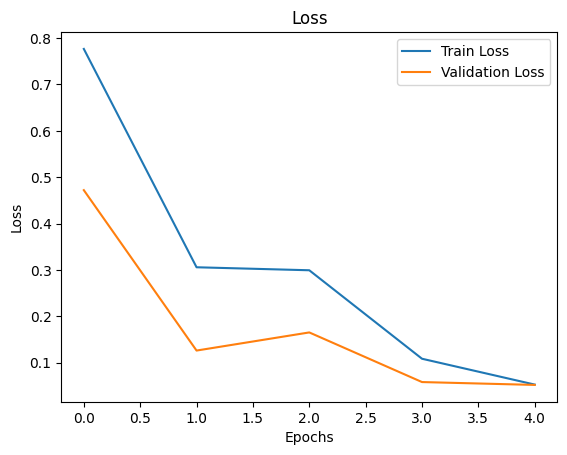

147/147 [==============================] - 1s 5ms/step


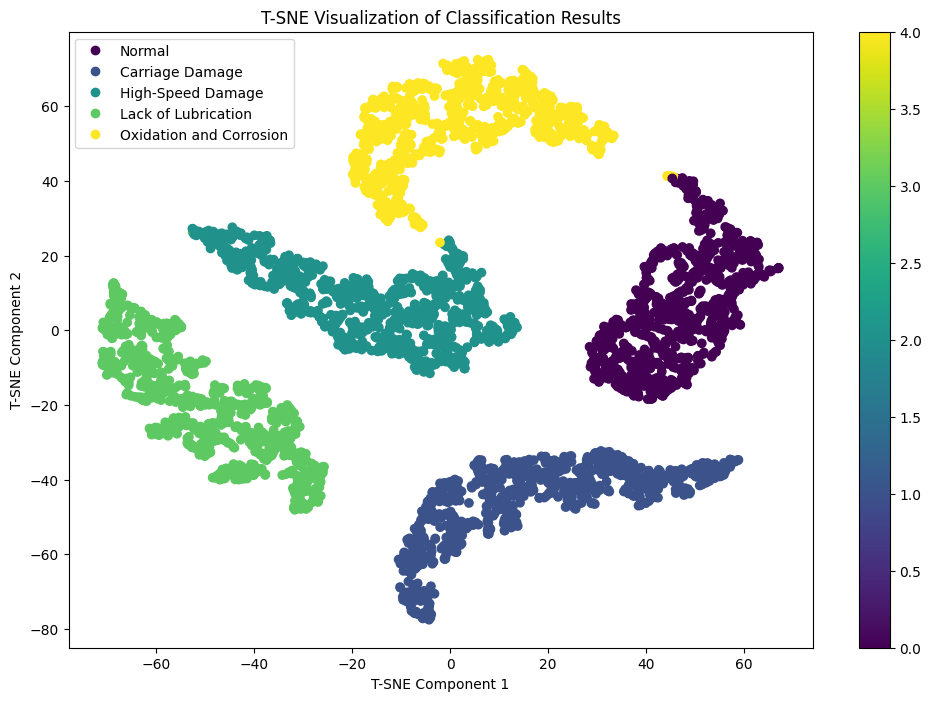

Accuracy on test set: 0.9861288945795988
                         precision    recall  f1-score   support

                 Normal       1.00      0.99      0.99       937
        Carriage Damage       1.00      1.00      1.00       938
      High-Speed Damage       0.95      1.00      0.97       937
    Lack of Lubrication       1.00      0.98      0.99       937
Oxidation and Corrosion       0.99      0.96      0.98       937

               accuracy                           0.99      4686
              macro avg       0.99      0.99      0.99      4686
           weighted avg       0.99      0.99      0.99      4686

Training classifier model...
Epoch 1/1000
147/147 [==============================] - 2s 6ms/step - loss: 0.4185 - accuracy: 0.8856 - val_loss: 0.0412 - val_accuracy: 0.9910
Epoch 2/1000
147/147 [==============================] - 1s 5ms/step - loss: 0.0822 - accuracy: 0.9831 - val_loss: 0.0406 - val_accuracy: 0.9908
Epoch 3/1000
147/147 [==============================] 

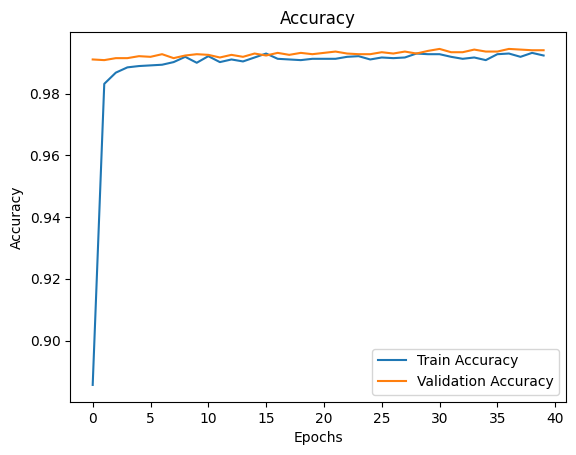

147/147 [==============================] - 0s 2ms/step


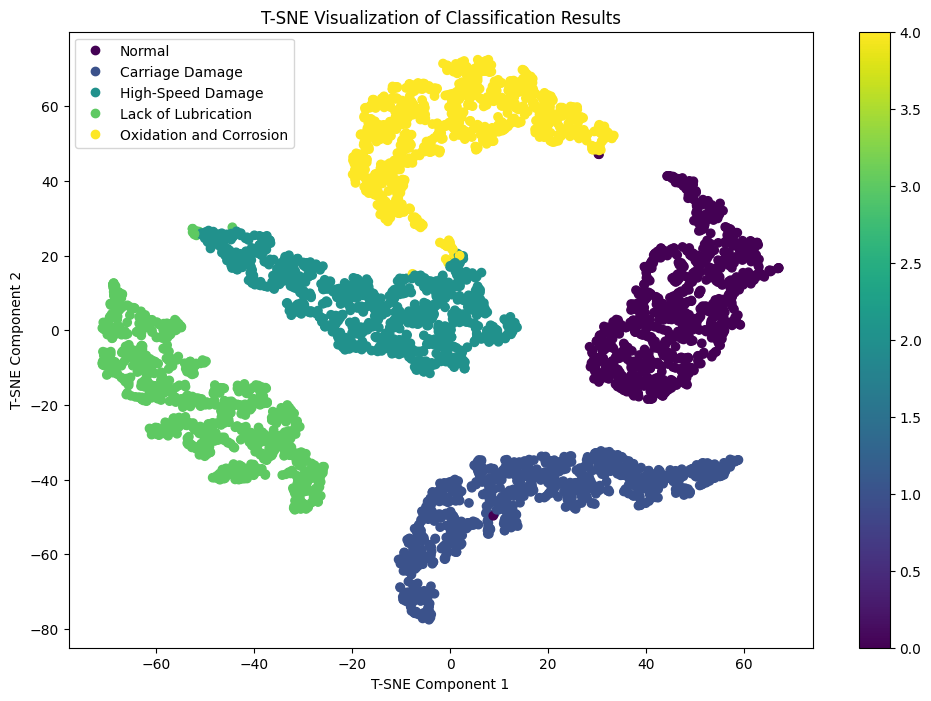

Accuracy on test set: 0.9940247545881349
                         precision    recall  f1-score   support

                 Normal       1.00      1.00      1.00       937
        Carriage Damage       1.00      1.00      1.00       938
      High-Speed Damage       0.98      1.00      0.99       937
    Lack of Lubrication       1.00      0.99      0.99       937
Oxidation and Corrosion       1.00      0.99      0.99       937

               accuracy                           0.99      4686
              macro avg       0.99      0.99      0.99      4686
           weighted avg       0.99      0.99      0.99      4686



In [9]:
############################################ LSTM #####################################################
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import scipy.signal
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE
from keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# 데이터 파일 로드 및 정규화
def normalize_data(df, features):
    scaler = StandardScaler()
    return scaler.fit_transform(df[features])

# 데이터 파일 로드
normal_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm normal data/stream2024_4_22_23_22.csv")
carriage_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm carriage damage/stream2024_4_23_2_56.csv")
highspeed_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm high-speed damage/stream2024_4_23_0_20.csv")
lack_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm lack of lubrication/stream2024_4_23_2_6.csv")
corrosion_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm oxidation and corrosion/stream2024_4_23_1_15.csv")

features = ['motor1_x', 'motor1_y', 'motor1_z', 'sound']
normal_data_scaled = normalize_data(normal_data, features)
carriage_data_scaled = normalize_data(carriage_data, features)
highspeed_data_scaled = normalize_data(highspeed_data, features)
lack_data_scaled = normalize_data(lack_data, features)
corrosion_data_scaled = normalize_data(corrosion_data, features)

def create_graph_data(data, k_neighbors=2):
    knn_graph = kneighbors_graph(data, k_neighbors, mode='connectivity', include_self=True)
    edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)
    x = torch.tensor(data, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

normal_graph = create_graph_data(normal_data_scaled)
carriage_graph = create_graph_data(carriage_data_scaled)
highspeed_graph = create_graph_data(highspeed_data_scaled)
lack_graph = create_graph_data(lack_data_scaled)
corrosion_graph = create_graph_data(corrosion_data_scaled)

# GCN 모델 정의
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# GCN 모델 학습 및 특징 추출
def train_gcn(graph_data, epochs=10):
    model = GCN(in_channels=graph_data.x.shape[1], hidden_channels=16, out_channels=graph_data.x.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph_data)
        loss = F.mse_loss(out, graph_data.x)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
    return model, out.detach().numpy()

print("Training GCN model for normal data...")
normal_model, normal_gcn_features = train_gcn(normal_graph)
print("Training GCN model for carriage damage data...")
carriage_model, carriage_gcn_features = train_gcn(carriage_graph)
print("Training GCN model for high-speed damage data...")
highspeed_model, highspeed_gcn_features = train_gcn(highspeed_graph)
print("Training GCN model for lack of lubrication data...")
lack_model, lack_gcn_features = train_gcn(lack_graph)
print("Training GCN model for corrosion data...")
corrosion_model, corrosion_gcn_features = train_gcn(corrosion_graph)

# 슬라이딩 윈도우 함수 정의
def sliding_window(data, window_size, step_size):
    n_samples = data.shape[0]
    windows = []
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return np.array(windows)

window_size = 128
step_size = 64

# 슬라이딩 윈도우 적용
normal_windows = sliding_window(normal_gcn_features, window_size, step_size)
carriage_windows = sliding_window(carriage_gcn_features, window_size, step_size)
highspeed_windows = sliding_window(highspeed_gcn_features, window_size, step_size)
lack_windows = sliding_window(lack_gcn_features, window_size, step_size)
corrosion_windows = sliding_window(corrosion_gcn_features, window_size, step_size)

# STFT 수행
fs = 5000
def compute_stft(data):
    return np.array([np.abs(scipy.signal.stft(d, fs=fs, nperseg=min(d.shape[-1], 256))[2]) for d in data])  # 절대값을 사용하여 실수 데이터로 변환

print("Computing STFT...")
normal_stft = compute_stft(normal_windows)
carriage_stft = compute_stft(carriage_windows)
highspeed_stft = compute_stft(highspeed_windows)
lack_stft = compute_stft(lack_windows)
corrosion_stft = compute_stft(corrosion_windows)

# 데이터 합치기
def concatenate_data(*stft_data):
    min_time_steps = min(stft.shape[2] for stft in stft_data)
    return np.concatenate([stft[:, :, :min_time_steps] for stft in stft_data], axis=0)

X_normal = concatenate_data(normal_stft)
X_carriage = concatenate_data(carriage_stft)
X_highspeed = concatenate_data(highspeed_stft)
X_lack = concatenate_data(lack_stft)
X_corrosion = concatenate_data(corrosion_stft)

# 레이블 생성
y_normal = np.zeros(X_normal.shape[0])
y_carriage = np.ones(X_carriage.shape[0])
y_highspeed = np.full((X_highspeed.shape[0],), 2)
y_lack = np.full((X_lack.shape[0],), 3)
y_corrosion = np.full((X_corrosion.shape[0],), 4)

# 데이터셋 합치기
X = np.concatenate((X_normal, X_carriage, X_highspeed, X_lack, X_corrosion), axis=0)
y = np.concatenate((y_normal, y_carriage, y_highspeed, y_lack, y_corrosion), axis=0)

# 레이블을 원-핫 인코딩으로 변환
y = to_categorical(y)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 형태 확인
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# 데이터 형태 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)  # (샘플 수, 시간, 특징 수)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
print("Train data shape after reshape:", X_train.shape)
print("Test data shape after reshape:", X_test.shape)

# LSTM 모델 정의
def create_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    return model

input_shape = (X_train.shape[1], X_train.shape[2])  # (시간, 특징 수)
model = create_lstm(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 얼리스탑 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# 모델 훈련
print("Training LSTM model...")
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 모델 서머리
model.summary()

# 훈련 및 검증 데이터에 대한 손실 확인
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 훈련 및 검증 데이터에 대한 손실 그래프
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 테스트 데이터에 대한 예측 및 평가
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# 분류 결과의 T-SNE 시각화
encoder = Model(inputs=model.input, outputs=model.layers[-2].output)
X_test_encoded = encoder.predict(X_test)
tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(X_test_encoded)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test_pred_classes, cmap='viridis')
plt.colorbar()
plt.title("T-SNE Visualization of Classification Results")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion'])
plt.show()

print("Accuracy on test set:", accuracy_score(y_test_true_classes, y_test_pred_classes))
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion']))

# 다중 클래스 분류 모델 정의
classifier = Sequential()
classifier.add(Dense(64, input_shape=(X_test_encoded.shape[1],)))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.5))
classifier.add(Dense(32))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.2))
classifier.add(Dense(y_train.shape[1], activation='softmax'))

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 다중 클래스 분류 모델 훈련
print("Training classifier model...")
history = classifier.fit(X_test_encoded, y_test, epochs=1000, batch_size=32, validation_data=(X_test_encoded, y_test), callbacks=[early_stopping])

# 분류 모델 서머리
classifier.summary()

# 훈련 및 검증 데이터에 대한 손실 및 정확도 확인
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 훈련 및 검증 데이터에 대한 손실 및 정확도 그래프
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 테스트 데이터에 대한 예측 및 평가
y_test_pred = classifier.predict(X_test_encoded)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# 분류 결과의 T-SNE 시각화
X_test_tsne = tsne.fit_transform(X_test_encoded)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test_pred_classes, cmap='viridis')
plt.colorbar()
plt.title("T-SNE Visualization of Classification Results")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion'])
plt.show()

print("Accuracy on test set:", accuracy_score(y_test_true_classes, y_test_pred_classes))
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion']))


Training GCN model for normal data...
Epoch 0/10, Loss: 1.8278933763504028
Training GCN model for carriage damage data...
Epoch 0/10, Loss: 1.4824941158294678
Training GCN model for high-speed damage data...
Epoch 0/10, Loss: 1.3736279010772705
Training GCN model for lack of lubrication data...
Epoch 0/10, Loss: 1.4519610404968262
Training GCN model for corrosion data...
Epoch 0/10, Loss: 1.3834491968154907
Computing STFT...
Train data shape: (18744, 128, 3, 3)
Test data shape: (4686, 128, 3, 3)
Train data shape after reshape: (18744, 128, 3, 3, 1)
Test data shape after reshape: (4686, 128, 3, 3, 1)
Training ConvLSTM Autoencoder model...
Epoch 1/5
147/147 [==============================] - 351s 2s/step - loss: 0.0327 - val_loss: 0.0292
Epoch 2/5
147/147 [==============================] - 332s 2s/step - loss: 0.0293 - val_loss: 0.0292
Epoch 3/5
147/147 [==============================] - 336s 2s/step - loss: 0.0293 - val_loss: 0.0292
Epoch 4/5
147/147 [==============================] - 3

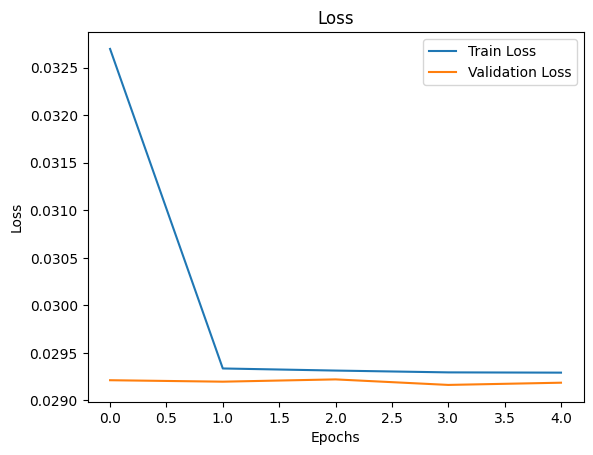

147/147 [==============================] - 25s 171ms/step


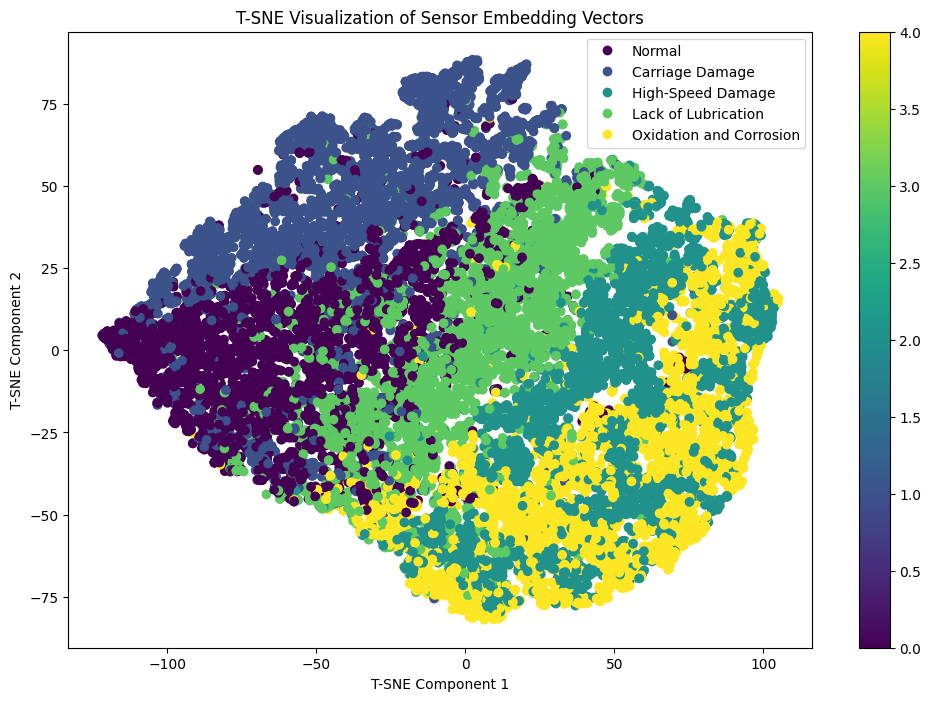

Training classifier model...
Epoch 1/1000
586/586 [==============================] - 5s 6ms/step - loss: 1.6171 - accuracy: 0.1995 - val_loss: 1.6096 - val_accuracy: 0.2000
Epoch 2/1000
586/586 [==============================] - 3s 4ms/step - loss: 1.6099 - accuracy: 0.2034 - val_loss: 1.6322 - val_accuracy: 0.2000
Epoch 3/1000
586/586 [==============================] - 2s 4ms/step - loss: 1.6104 - accuracy: 0.2007 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 4/1000
586/586 [==============================] - 2s 4ms/step - loss: 1.6101 - accuracy: 0.1999 - val_loss: 1.6096 - val_accuracy: 0.2000
Epoch 5/1000
586/586 [==============================] - 3s 6ms/step - loss: 1.6101 - accuracy: 0.2002 - val_loss: 1.6098 - val_accuracy: 0.2000
Epoch 6/1000
586/586 [==============================] - 3s 5ms/step - loss: 1.6104 - accuracy: 0.1970 - val_loss: 1.6095 - val_accuracy: 0.2002
Epoch 7/1000
586/586 [==============================] - 2s 4ms/step - loss: 1.6100 - accuracy: 0.1952 - val

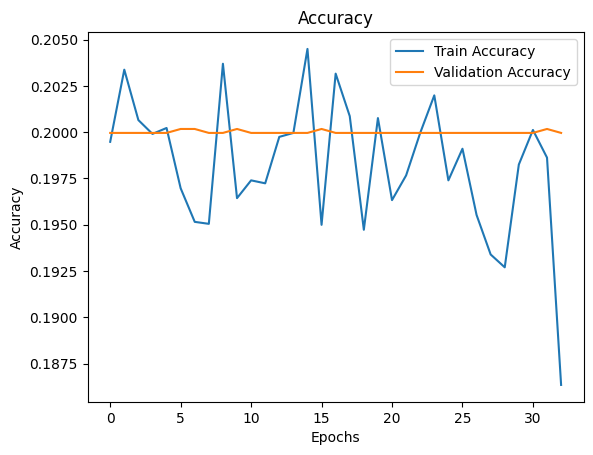

147/147 [==============================] - 0s 2ms/step


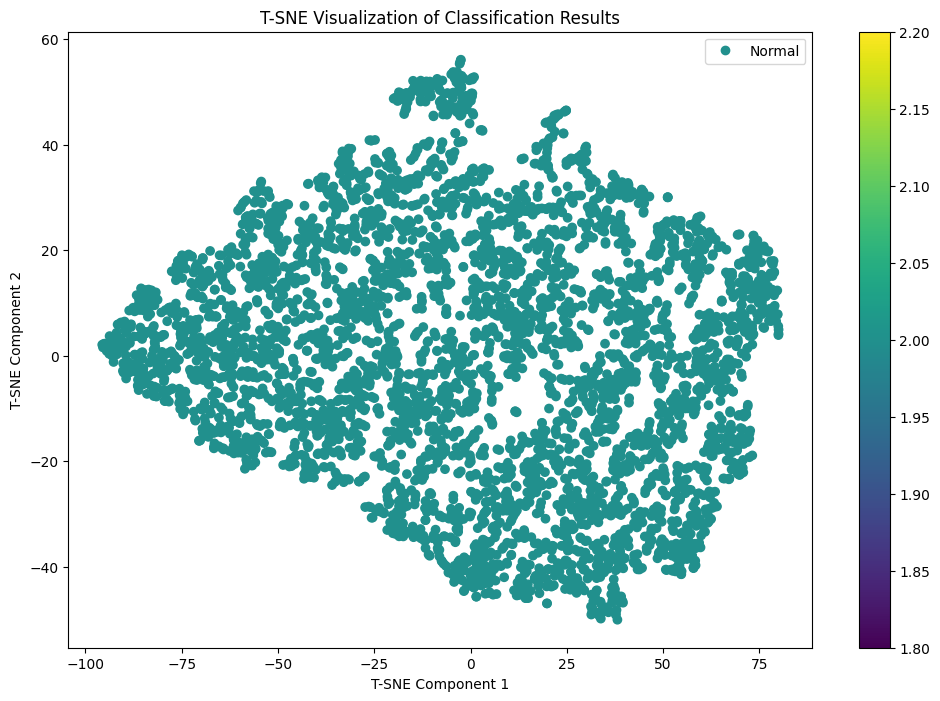

Accuracy on test set: 0.19995731967562955
                         precision    recall  f1-score   support

                 Normal       0.00      0.00      0.00       937
        Carriage Damage       0.00      0.00      0.00       938
      High-Speed Damage       0.20      1.00      0.33       937
    Lack of Lubrication       0.00      0.00      0.00       937
Oxidation and Corrosion       0.00      0.00      0.00       937

               accuracy                           0.20      4686
              macro avg       0.04      0.20      0.07      4686
           weighted avg       0.04      0.20      0.07      4686



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import scipy.signal
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, TimeDistributed, Input, LeakyReLU, Reshape
from tensorflow.keras.layers import ConvLSTM2D, Conv2D, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE
from keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# 데이터 파일 로드 및 정규화
def normalize_data(df, features):
    scaler = StandardScaler()
    return scaler.fit_transform(df[features])

# 데이터 파일 로드
normal_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm normal data/stream2024_4_22_23_22.csv")
carriage_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm carriage damage/stream2024_4_23_2_56.csv")
highspeed_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm high-speed damage/stream2024_4_23_0_20.csv")
lack_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm lack of lubrication/stream2024_4_23_2_6.csv")
corrosion_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm oxidation and corrosion/stream2024_4_23_1_15.csv")

features = ['motor1_x', 'motor1_y', 'motor1_z', 'sound']
normal_data_scaled = normalize_data(normal_data, features)
carriage_data_scaled = normalize_data(carriage_data, features)
highspeed_data_scaled = normalize_data(highspeed_data, features)
lack_data_scaled = normalize_data(lack_data, features)
corrosion_data_scaled = normalize_data(corrosion_data, features)

def create_graph_data(data, k_neighbors=2):
    knn_graph = kneighbors_graph(data, k_neighbors, mode='connectivity', include_self=True)
    edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)
    x = torch.tensor(data, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

normal_graph = create_graph_data(normal_data_scaled)
carriage_graph = create_graph_data(carriage_data_scaled)
highspeed_graph = create_graph_data(highspeed_data_scaled)
lack_graph = create_graph_data(lack_data_scaled)
corrosion_graph = create_graph_data(corrosion_data_scaled)

# GCN 모델 정의
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# GCN 모델 학습 및 특징 추출
def train_gcn(graph_data, epochs=10):
    model = GCN(in_channels=graph_data.x.shape[1], hidden_channels=16, out_channels=graph_data.x.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph_data)
        loss = F.mse_loss(out, graph_data.x)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
    return model, out.detach().numpy()

print("Training GCN model for normal data...")
normal_model, normal_gcn_features = train_gcn(normal_graph)
print("Training GCN model for carriage damage data...")
carriage_model, carriage_gcn_features = train_gcn(carriage_graph)
print("Training GCN model for high-speed damage data...")
highspeed_model, highspeed_gcn_features = train_gcn(highspeed_graph)
print("Training GCN model for lack of lubrication data...")
lack_model, lack_gcn_features = train_gcn(lack_graph)
print("Training GCN model for corrosion data...")
corrosion_model, corrosion_gcn_features = train_gcn(corrosion_graph)

# 슬라이딩 윈도우 함수 정의
def sliding_window(data, window_size, step_size):
    n_samples = data.shape[0]
    windows = []
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return np.array(windows)

window_size = 128
step_size = 64

# 슬라이딩 윈도우 적용
normal_windows = sliding_window(normal_gcn_features, window_size, step_size)
carriage_windows = sliding_window(carriage_gcn_features, window_size, step_size)
highspeed_windows = sliding_window(highspeed_gcn_features, window_size, step_size)
lack_windows = sliding_window(lack_gcn_features, window_size, step_size)
corrosion_windows = sliding_window(corrosion_gcn_features, window_size, step_size)

# STFT 수행
fs = 5000
def compute_stft(data):
    return np.array([np.abs(scipy.signal.stft(d, fs=fs, nperseg=min(d.shape[-1], 256))[2]) for d in data])  # 절대값을 사용하여 실수 데이터로 변환

print("Computing STFT...")
normal_stft = compute_stft(normal_windows)
carriage_stft = compute_stft(carriage_windows)
highspeed_stft = compute_stft(highspeed_windows)
lack_stft = compute_stft(lack_windows)
corrosion_stft = compute_stft(corrosion_windows)

# 데이터 합치기
def concatenate_data(*stft_data):
    min_time_steps = min(stft.shape[2] for stft in stft_data)
    return np.concatenate([stft[:, :, :min_time_steps] for stft in stft_data], axis=0)

X_normal = concatenate_data(normal_stft)
X_carriage = concatenate_data(carriage_stft)
X_highspeed = concatenate_data(highspeed_stft)
X_lack = concatenate_data(lack_stft)
X_corrosion = concatenate_data(corrosion_stft)

# 레이블 생성
y_normal = np.zeros(X_normal.shape[0])
y_carriage = np.ones(X_carriage.shape[0])
y_highspeed = np.full((X_highspeed.shape[0],), 2)
y_lack = np.full((X_lack.shape[0],), 3)
y_corrosion = np.full((X_corrosion.shape[0],), 4)

# 데이터셋 합치기
X = np.concatenate((X_normal, X_carriage, X_highspeed, X_lack, X_corrosion), axis=0)
y = np.concatenate((y_normal, y_carriage, y_highspeed, y_lack, y_corrosion), axis=0)

# 레이블을 원-핫 인코딩으로 변환
y = to_categorical(y)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 형태 확인
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# 데이터 형태 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)  # (샘플 수, 시간, 특징 수, 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3], 1)
print("Train data shape after reshape:", X_train.shape)
print("Test data shape after reshape:", X_test.shape)

# ConvLSTM Autoencoder 모델 정의
def create_convlstm_ae(input_shape):
    inputs = Input(shape=input_shape)
    encoded = ConvLSTM2D(64, (3, 3), return_sequences=True, padding='same')(inputs)
    encoded = ConvLSTM2D(32, (3, 3), return_sequences=False, padding='same')(encoded)
    encoded = Reshape((1, input_shape[1], input_shape[2], 32))(encoded)
    repeated = tf.keras.layers.UpSampling3D(size=(input_shape[0], 1, 1))(encoded)
    decoded = ConvLSTM2D(32, (3, 3), return_sequences=True, padding='same')(repeated)
    decoded = ConvLSTM2D(64, (3, 3), return_sequences=True, padding='same')(decoded)
    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)
    model = Model(inputs, outputs)
    return model

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)  # (시간, 특징 수, 1)
model = create_convlstm_ae(input_shape)
model.compile(optimizer='adam', loss='mse')

# 얼리스탑 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# 모델 훈련
print("Training ConvLSTM Autoencoder model...")
history = model.fit(X_train, X_train, epochs=5, batch_size=128, validation_data=(X_test, X_test), callbacks=[early_stopping])

# 모델 서머리
model.summary()

# 훈련 및 검증 데이터에 대한 손실 확인
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 훈련 및 검증 데이터에 대한 손실 그래프
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ConvLSTM Autoencoder에서 인코딩된 특징 추출
encoder = Model(inputs=model.input, outputs=model.layers[3].output)
encoder_output_shape = model.layers[3].output_shape[1:]

# 인코더 출력의 크기를 일치시키기 위해 Reshape 적용
X_train_encoded = encoder.predict(X_train)
X_train_encoded = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
X_test_encoded = encoder.predict(X_test)
X_test_encoded = X_test_encoded.reshape(X_test_encoded.shape[0], -1)

# T-SNE를 사용한 시각화
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(np.concatenate((X_train_encoded, X_test_encoded)))

# 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.argmax(np.concatenate((y_train, y_test)), axis=1), cmap='viridis')
plt.colorbar()
plt.title("T-SNE Visualization of Sensor Embedding Vectors")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion'])
plt.show()

# 다중 클래스 분류 모델 정의
classifier = Sequential()
classifier.add(Dense(64, input_shape=(X_train_encoded.shape[1],)))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.5))
classifier.add(Dense(32))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.2))
classifier.add(Dense(y_train.shape[1], activation='softmax'))

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 다중 클래스 분류 모델 훈련
print("Training classifier model...")
history = classifier.fit(X_train_encoded, y_train, epochs=1000, batch_size=32, validation_data=(X_test_encoded, y_test), callbacks=[early_stopping])

# 분류 모델 서머리
classifier.summary()

# 훈련 및 검증 데이터에 대한 손실 및 정확도 확인
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 훈련 및 검증 데이터에 대한 손실 및 정확도 그래프
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 테스트 데이터에 대한 예측 및 평가
y_test_pred = classifier.predict(X_test_encoded)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# 분류 결과의 T-SNE 시각화
X_test_tsne = tsne.fit_transform(X_test_encoded)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test_pred_classes, cmap='viridis')
plt.colorbar()
plt.title("T-SNE Visualization of Classification Results")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion'])
plt.show()

print("Accuracy on test set:", accuracy_score(y_test_true_classes, y_test_pred_classes))
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion']))


Training GCN model for normal data...
Epoch 0/10, Loss: 1.5763070583343506
Training GCN model for carriage damage data...
Epoch 0/10, Loss: 1.4774131774902344
Training GCN model for high-speed damage data...
Epoch 0/10, Loss: 1.0674740076065063
Training GCN model for lack of lubrication data...
Epoch 0/10, Loss: 1.2701799869537354
Training GCN model for corrosion data...
Epoch 0/10, Loss: 1.5906215906143188
Computing STFT...
Training Transformer model...
Epoch 1/5
147/147 [==============================] - 35s 161ms/step - loss: 0.2170 - accuracy: 0.9147 - val_loss: 0.0030 - val_accuracy: 0.9987
Epoch 2/5
147/147 [==============================] - 23s 155ms/step - loss: 0.0169 - accuracy: 0.9949 - val_loss: 6.8371e-04 - val_accuracy: 0.9998
Epoch 3/5
147/147 [==============================] - 22s 152ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 7.1457e-05 - val_accuracy: 1.0000
Epoch 4/5
147/147 [==============================] - 23s 153ms/step - loss: 0.0115 - accuracy: 0.9969

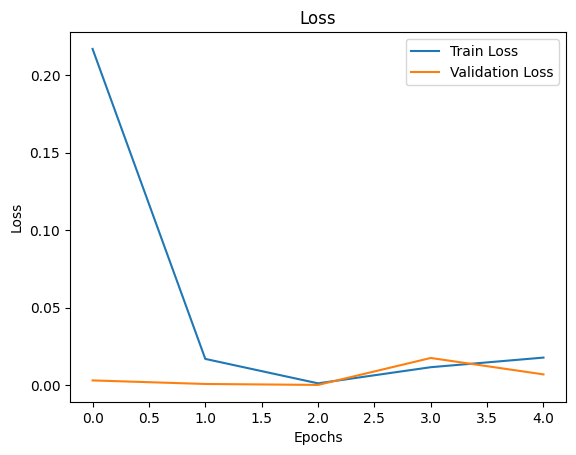

147/147 [==============================] - 3s 17ms/step


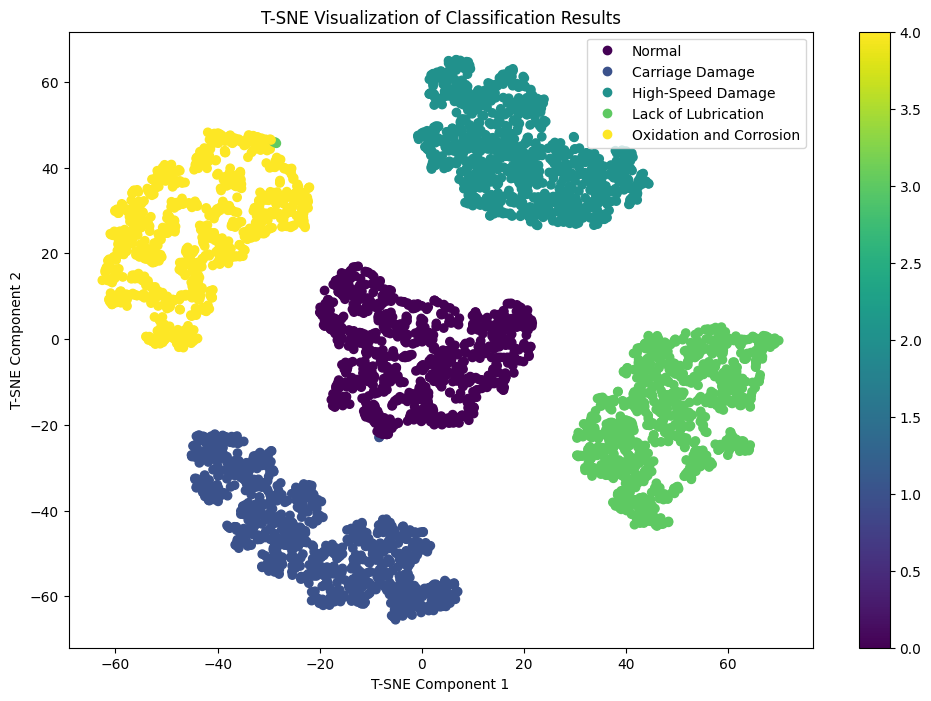

Accuracy on test set: 0.998719590268886
                         precision    recall  f1-score   support

                 Normal       1.00      1.00      1.00       937
        Carriage Damage       1.00      1.00      1.00       938
      High-Speed Damage       1.00      1.00      1.00       937
    Lack of Lubrication       1.00      1.00      1.00       937
Oxidation and Corrosion       1.00      1.00      1.00       937

               accuracy                           1.00      4686
              macro avg       1.00      1.00      1.00      4686
           weighted avg       1.00      1.00      1.00      4686

Training classifier model...
Epoch 1/1000
147/147 [==============================] - 2s 7ms/step - loss: 0.4770 - accuracy: 0.8927 - val_loss: 0.0035 - val_accuracy: 0.9994
Epoch 2/1000
147/147 [==============================] - 1s 6ms/step - loss: 0.0391 - accuracy: 0.9880 - val_loss: 0.0012 - val_accuracy: 0.9994
Epoch 3/1000
147/147 [==============================] -

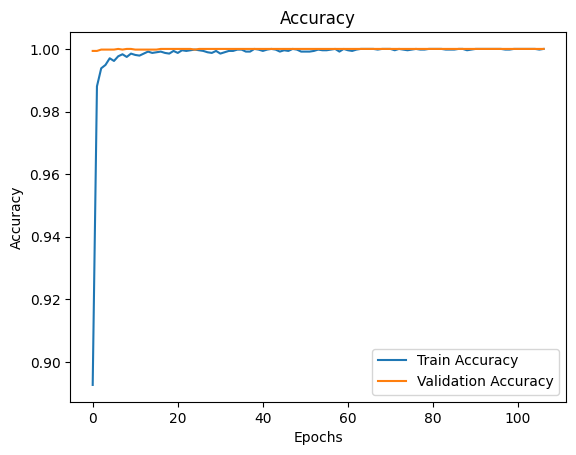

147/147 [==============================] - 0s 2ms/step


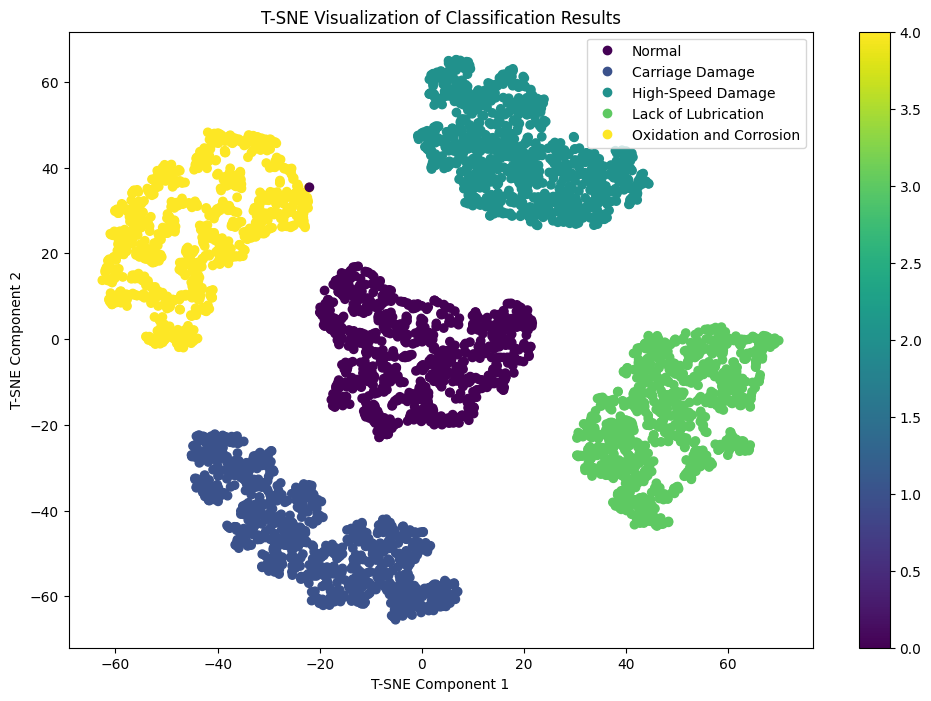

Accuracy on test set: 1.0
                         precision    recall  f1-score   support

                 Normal       1.00      1.00      1.00       937
        Carriage Damage       1.00      1.00      1.00       938
      High-Speed Damage       1.00      1.00      1.00       937
    Lack of Lubrication       1.00      1.00      1.00       937
Oxidation and Corrosion       1.00      1.00      1.00       937

               accuracy                           1.00      4686
              macro avg       1.00      1.00      1.00      4686
           weighted avg       1.00      1.00      1.00      4686



In [11]:
######################################### Transformer ################################################
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import scipy.signal
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE
from keras.layers import Layer, MultiHeadAttention, LayerNormalization, Add
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# 데이터 파일 로드 및 정규화
def normalize_data(df, features):
    scaler = StandardScaler()
    return scaler.fit_transform(df[features])

# 데이터 파일 로드
normal_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm normal data/stream2024_4_22_23_22.csv")
carriage_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm carriage damage/stream2024_4_23_2_56.csv")
highspeed_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm high-speed damage/stream2024_4_23_0_20.csv")
lack_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm lack of lubrication/stream2024_4_23_2_6.csv")
corrosion_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/5000hz/300rpm/300rpm oxidation and corrosion/stream2024_4_23_1_15.csv")

features = ['motor1_x', 'motor1_y', 'motor1_z', 'sound']
normal_data_scaled = normalize_data(normal_data, features)
carriage_data_scaled = normalize_data(carriage_data, features)
highspeed_data_scaled = normalize_data(highspeed_data, features)
lack_data_scaled = normalize_data(lack_data, features)
corrosion_data_scaled = normalize_data(corrosion_data, features)

def create_graph_data(data, k_neighbors=2):
    knn_graph = kneighbors_graph(data, k_neighbors, mode='connectivity', include_self=True)
    edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)
    x = torch.tensor(data, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

normal_graph = create_graph_data(normal_data_scaled)
carriage_graph = create_graph_data(carriage_data_scaled)
highspeed_graph = create_graph_data(highspeed_data_scaled)
lack_graph = create_graph_data(lack_data_scaled)
corrosion_graph = create_graph_data(corrosion_data_scaled)

# GCN 모델 정의
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# GCN 모델 학습 및 특징 추출
def train_gcn(graph_data, epochs=10):
    model = GCN(in_channels=graph_data.x.shape[1], hidden_channels=16, out_channels=graph_data.x.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph_data)
        loss = F.mse_loss(out, graph_data.x)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
    return model, out.detach().numpy()

print("Training GCN model for normal data...")
normal_model, normal_gcn_features = train_gcn(normal_graph)
print("Training GCN model for carriage damage data...")
carriage_model, carriage_gcn_features = train_gcn(carriage_graph)
print("Training GCN model for high-speed damage data...")
highspeed_model, highspeed_gcn_features = train_gcn(highspeed_graph)
print("Training GCN model for lack of lubrication data...")
lack_model, lack_gcn_features = train_gcn(lack_graph)
print("Training GCN model for corrosion data...")
corrosion_model, corrosion_gcn_features = train_gcn(corrosion_graph)

# 슬라이딩 윈도우 함수 정의
def sliding_window(data, window_size, step_size):
    n_samples = data.shape[0]
    windows = []
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return np.array(windows)

window_size = 128
step_size = 64

# 슬라이딩 윈도우 적용
normal_windows = sliding_window(normal_gcn_features, window_size, step_size)
carriage_windows = sliding_window(carriage_gcn_features, window_size, step_size)
highspeed_windows = sliding_window(highspeed_gcn_features, window_size, step_size)
lack_windows = sliding_window(lack_gcn_features, window_size, step_size)
corrosion_windows = sliding_window(corrosion_gcn_features, window_size, step_size)

# STFT 수행
fs = 5000
def compute_stft(data):
    return np.array([np.abs(scipy.signal.stft(d, fs=fs, nperseg=min(d.shape[-1], 256))[2]) for d in data])  # 절대값을 사용하여 실수 데이터로 변환

print("Computing STFT...")
normal_stft = compute_stft(normal_windows)
carriage_stft = compute_stft(carriage_windows)
highspeed_stft = compute_stft(highspeed_windows)
lack_stft = compute_stft(lack_windows)
corrosion_stft = compute_stft(corrosion_windows)

# 데이터 합치기
def concatenate_data(*stft_data):
    min_time_steps = min(stft.shape[2] for stft in stft_data)
    return np.concatenate([stft[:, :, :min_time_steps] for stft in stft_data], axis=0)

X_normal = concatenate_data(normal_stft)
X_carriage = concatenate_data(carriage_stft)
X_highspeed = concatenate_data(highspeed_stft)
X_lack = concatenate_data(lack_stft)
X_corrosion = concatenate_data(corrosion_stft)

# 레이블 생성
y_normal = np.zeros(X_normal.shape[0])
y_carriage = np.ones(X_carriage.shape[0])
y_highspeed = np.full((X_highspeed.shape[0],), 2)
y_lack = np.full((X_lack.shape[0],), 3)
y_corrosion = np.full((X_corrosion.shape[0],), 4)

# 데이터셋 합치기
X = np.concatenate((X_normal, X_carriage, X_highspeed, X_lack, X_corrosion), axis=0)
y = np.concatenate((y_normal, y_carriage, y_highspeed, y_lack, y_corrosion), axis=0)

# 레이블을 원-핫 인코딩으로 변환
y = to_categorical(y)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 형태 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)  # (샘플 수, 시간, 특징 수)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

# Transformer 모델 정의
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = Flatten()(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(y_train.shape[1], activation="softmax")(x)
    return Model(inputs, outputs)

input_shape = X_train.shape[1:]  # (시간, 특징 수)
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=256,
    num_transformer_blocks=4,
    mlp_units=[128],
    dropout=0.1,
    mlp_dropout=0.1,
)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 얼리스탑 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# 모델 훈련
print("Training Transformer model...")
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 모델 서머리
model.summary()

# 훈련 및 검증 데이터에 대한 손실 확인
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 훈련 및 검증 데이터에 대한 손실 그래프
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 테스트 데이터에 대한 예측 및 평가
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# 분류 결과의 T-SNE 시각화
encoder = Model(inputs=model.input, outputs=model.layers[-2].output)
X_test_encoded = encoder.predict(X_test)
tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(X_test_encoded)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test_pred_classes, cmap='viridis')
plt.colorbar()
plt.title("T-SNE Visualization of Classification Results")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion'])
plt.show()

print("Accuracy on test set:", accuracy_score(y_test_true_classes, y_test_pred_classes))
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion']))

# 다중 클래스 분류 모델 정의
classifier = Sequential()
classifier.add(Dense(64, input_shape=(X_test_encoded.shape[1],)))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.5))
classifier.add(Dense(32))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.2))
classifier.add(Dense(y_train.shape[1], activation='softmax'))

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 다중 클래스 분류 모델 훈련
print("Training classifier model...")
history = classifier.fit(X_test_encoded, y_test, epochs=1000, batch_size=32, validation_data=(X_test_encoded, y_test), callbacks=[early_stopping])

# 분류 모델 서머리
classifier.summary()

# 훈련 및 검증 데이터에 대한 손실 및 정확도 확인
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 훈련 및 검증 데이터에 대한 손실 및 정확도 그래프
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 테스트 데이터에 대한 예측 및 평가
y_test_pred = classifier.predict(X_test_encoded)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# 분류 결과의 T-SNE 시각화
X_test_tsne = tsne.fit_transform(X_test_encoded)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test_pred_classes, cmap='viridis')
plt.colorbar()
plt.title("T-SNE Visualization of Classification Results")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion'])
plt.show()

print("Accuracy on test set:", accuracy_score(y_test_true_classes, y_test_pred_classes))
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=['Normal', 'Carriage Damage', 'High-Speed Damage', 'Lack of Lubrication', 'Oxidation and Corrosion']))
